Name: Stephen Lacey

Student ID: 21165335

# Etivity 5: Regression and Dimensionality Reduction

## Task 2

Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# SL - extra imports etivity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
import umap
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.svm import SVC

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

We start with a brief EDA to check for missing values and outliers.

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Let's examine values in the categorical column `insurance_cost` first.

In [4]:
df['insurance_cost'].value_counts()

1639.56310     2
6555.07035     1
9620.33070     1
22462.04375    1
8827.20990     1
              ..
6799.45800     1
12347.17200    1
62592.87309    1
7726.85400     1
7731.42710     1
Name: insurance_cost, Length: 1337, dtype: int64

Now, let's check for missing values and outliers.

In [5]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [6]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

They all look OK

Next, let's check for outliers in the numerical columns. 

The items are scaled differently, so creating individual subplots per item with their own individual scales for clarity 

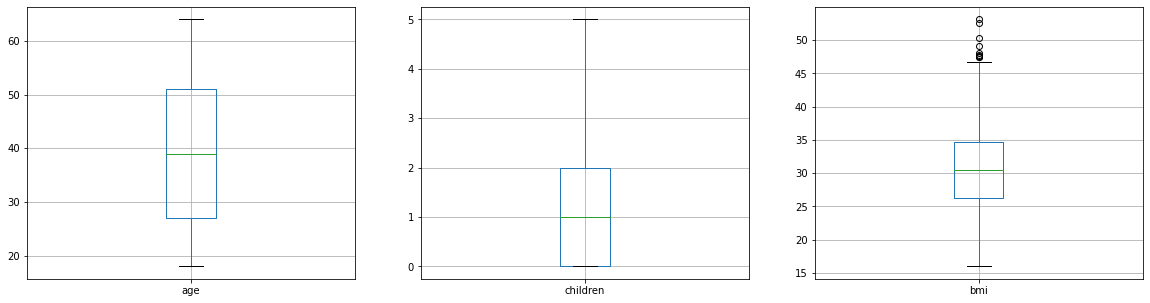

In [7]:
# create figure and axes
fig, axes = plt.subplots(1,3, figsize=(20,5)) 

# Loop through the items to boxplot
for i,el in enumerate(list(["age","children","bmi"])):
    a = df.boxplot(el, ax=axes.flatten()[i])

plt.show()

There are some outliers with bmi but they do not look like they need special treatement. 

## Data Preparation

Gender to be mapped to a true/false column. 1 for male, 0 for female


In [8]:
mapper = {'male': 1, 'female':0}
df['gender_male'] = df['gender'].replace(mapper)
df['gender_male'].value_counts()

1    676
0    662
Name: gender_male, dtype: int64

Likewise, smoker can be mapped to a binary field

In [9]:
mapper = {'yes': 1, 'no':0}
df['smoker'] = df['smoker'].replace(mapper)
df['smoker'].value_counts()

0    1064
1     274
Name: smoker, dtype: int64

Finally, examine the remaining categorical column - `region`. There is no logical numeric or binary value for this, so I will one-hot-encode it

In [10]:
df = pd.get_dummies(df, columns=['region'], 
                        dummy_na=False, 
                        drop_first=True)

Let's examine the transformed dataset.

In [11]:
df.drop(["gender"], inplace=True, axis=1)
df.head()

age     bmi  children  smoker  insurance_cost  gender_male  \
0   18  33.770         1       0      1725.55230            1   
1   18  34.100         0       0      1137.01100            1   
2   18  26.315         0       0      2198.18985            0   
3   18  38.665         2       0      3393.35635            0   
4   18  35.625         0       0      2211.13075            0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [12]:
df.tail()

age     bmi  children  smoker  insurance_cost  gender_male  \
1333   64  31.825         2       0     16069.08475            0   
1334   64  26.885         0       1     29330.98315            0   
1335   64  26.410         0       0     14394.55790            1   
1336   64  36.960         2       1     49577.66240            1   
1337   64  23.760         0       1     26926.51440            1   

      region_northwest  region_southeast  region_southwest  
1333                 0                 0                 0  
1334                 1                 0                 0  
1335                 0                 0                 0  
1336                 0                 1                 0  
1337                 0                 1                 0

#### Check the variances in case any feature has too low a variance

In [13]:
df.var()

age                 1.974014e+02
bmi                 3.718788e+01
children            1.453213e+00
smoker              1.629689e-01
insurance_cost      1.466524e+08
gender_male         2.501596e-01
region_northwest    1.840371e-01
region_southeast    1.981859e-01
region_southwest    1.840371e-01
dtype: float64

#### Check the correlations in case there are any features overly correlated

In [14]:
df.corr()

age       bmi  children    smoker  insurance_cost  \
age               1.000000  0.109272  0.042469 -0.025019        0.299008   
bmi               0.109272  1.000000  0.012759  0.003750        0.198341   
children          0.042469  0.012759  1.000000  0.007673        0.067998   
smoker           -0.025019  0.003750  0.007673  1.000000        0.787251   
insurance_cost    0.299008  0.198341  0.067998  0.787251        1.000000   
gender_male      -0.020856  0.046371  0.017163  0.076185        0.057292   
region_northwest -0.000407 -0.135996  0.024806 -0.036945       -0.039905   
region_southeast -0.011642  0.270025 -0.023066  0.068498        0.073982   
region_southwest  0.010016 -0.006205  0.021914 -0.036945       -0.043210   

                  gender_male  region_northwest  region_southeast  \
age                 -0.020856         -0.000407         -0.011642   
bmi                  0.046371         -0.135996          0.270025   
children             0.017163          0.024806         -0.023066   
smoker               0.076185         -0.036945          0.068498   
insurance_cost       0.057292         -0.039905          0.073982   
gender_male          1.000000         -0.011156          0.017117   
region_northwest    -0.011156          1.000000         -0.346265   
region_southeast     0.017117         -0.346265          1.000000   
region_southwest    -0.004184         -0.320829         -0.346265   

                  region_southwest  
age                       0.010016  
bmi                      -0.006205  
children                  0.021914  
smoker                   -0.036945  
insurance_cost           -0.043210  
gender_male              -0.004184  
region_northwest         -0.320829  
region_southeast         -0.346265  
region_southwest          1.000000

We have decided we don't need to handle the  outliers, the variances and correlations all look  fine - we will apply `StandardScaler` to all predictors.

In [15]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [16]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values
df.drop('insurance_cost', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next I will train on RandomForest and LinearRegression methods.  

I will first establish the original, non-dimensional reduced values, and save those as a baseline. Then I will get the domensional reduced values.  

### Random Forest Pipeline, no dimension reduction

First create a pipeline for no dim reduction for a baseline

In [17]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [18]:
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_orig_best_params = search.best_params_
RF_orig_best_model = search.best_estimator_

Best CV score = 0.836:
Best parameters:  {'regresson__max_depth': 4}


### Let us examine the feature importance for Random Forest

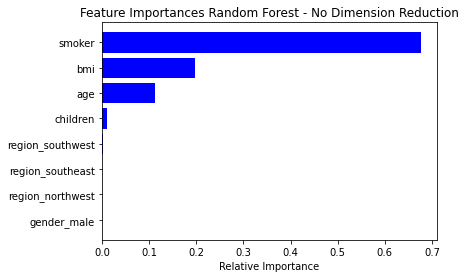

In [19]:
features = df.columns
importances = RF_orig_best_model[1].feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances Random Forest - No Dimension Reduction')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### It seems there are 4 very significant features

### Random forest, dimension reduction
The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best method.

In [20]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [21]:
N_FEATURES_OPTIONS = [2,4,6]
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.833:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


### Linear Regression Pipeline - No Dimension Reduction

Create a pipeline for Linear Regression with no dim reduction to record the baseline

In [22]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('regresson', LinearRegression())])

In [23]:
N_FEATURES_OPTIONS = [2,4,6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_orig_best_params = search.best_params_
LR_orig_best_model = search.best_estimator_

Best CV score = 0.720:
Best parameters:  {'regresson__normalize': False}


### Linear Regression Pipeline with dimension reduction

In [24]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [25]:
N_FEATURES_OPTIONS = [2,4,6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.721:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__normalize': False}


### Add a regression algorithm

#### SVR

Epsilon-Support Vector Regression.

### SVR - No Dimension Reduction

In [26]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('regresson', SVR())])

In [27]:
KERNEL_OPTIONS = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
GAMMA_OPTIONS = ["scale", "auto"]

param_grid = [
    {
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    {
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_orig_best_params = search.best_params_
SVR_orig_best_model = search.best_estimator_

Best CV score = -0.038:
Best parameters:  {'regresson__gamma': 'scale', 'regresson__kernel': 'linear'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.03793851 -0.10375248 -0.10547302 -0.10066234         nan -0.03793851
 -0.10375248 -0.10547302 -0.10066234         nan -0.03793851 -0.10375248
 -0.10547302 -0.10066234         nan -0.03793851 -0.10375248 -0.10547302
 -0.10066234         nan]
  warnings.warn(


### SVR - Dimension reduction

In [28]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR())])

In [29]:
N_FEATURES_OPTIONS = [2,4,6]
KERNEL_OPTIONS = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
GAMMA_OPTIONS = ["scale", "auto"]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.10401163 -0.10490754 -0.1082644  -0.10803204         nan -0.10401163
 -0.09720964 -0.10823494 -0.10792214         nan -0.09586311 -0.10537034
 -0.10768854 -0.10676989         nan -0.09586311 -0.10267936 -0.10773044
 -0.10654785         nan -0.03555148 -0.10155705 -0.10466028 -0.0993768
         nan -0.03555148 -0.09782766 -0.10489636 -0.09841669         nan
 -0.0391341  -0.00484182 -0.09569629 -0.08669832         nan -0.0391341
 -0.00484182 -0.09569629 -0.08669832         nan -0.03788615 -0.08784646
 -0.10202578 -0.09459262         nan -0.03788615 -0.08784646 -0.10202578
 -0.09459262         nan -0.03832011 -0.09989337 -0.10431864 -0.098453
         nan -0.03832011 -0.09989337 -0.10431864 -0.098453           nan
 -0.0391341  -0.00484182 -0.09569629 -0.08669832         nan -0.0391341
 -0.00484182 -0.09569629 -0.08669832         nan -0.0375369

Best CV score = -0.005:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'regresson__gamma': 'auto', 'regresson__kernel': 'poly'}


#### Well that regression performance is poor, let's try another

### Lasoo

Lasso is a modification of linear regression, where the model is penalized for the sum of absolute values of the weights

### Lasoo - no dimension reduction

In [30]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('regresson', linear_model.Lasso(alpha=1.0))])

In [31]:
NORMALIZE_OPTIONS = [True, False]

param_grid = [
    {
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
Lasoo_orig_best_params = search.best_params_
Lasoo_orig_best_model = search.best_estimator_

Best CV score = 0.721:
Best parameters:  {'regresson__normalize': True}


### Lasoo - with dimension reduction

In [32]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', linear_model.Lasso(alpha=1.0))])


In [33]:
N_FEATURES_OPTIONS = [2,4,6]
NORMALIZE_OPTIONS = [True, False]
GAMMA_OPTIONS = ["scale", "auto"]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
Lasoo_best_params = search.best_params_
Lasoo_best_model = search.best_estimator_

Best CV score = 0.721:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


The results suggest that Random Forest performs better. 

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [34]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
    
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest, Linear Regression, SVR and Lasso models found by the grid search.

In [35]:
### no dimension reduction
RF_orig_mse, RF_orig_mae, RF_orig_r2 = evaluate_model(X_test, y_test, RF_orig_best_model)
LR_orig_mse, LR_orig_mae, LR_orig_r2 = evaluate_model(X_test, y_test, LR_orig_best_model)
SVR_orig_mse, SVR_orig_mae, SVR_orig_r2 = evaluate_model(X_test, y_test, SVR_orig_best_model)
Lasoo_orig_mse, Lasoo_orig_mae, Lasoo_orig_r2 = evaluate_model(X_test, y_test, Lasoo_orig_best_model)

### With dimension reduction

RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)
Lasoo_mse, Lasoo_mae, Lasoo_r2 = evaluate_model(X_test, y_test, Lasoo_best_model)

We will use a Pandas bar plots to compare the results. 

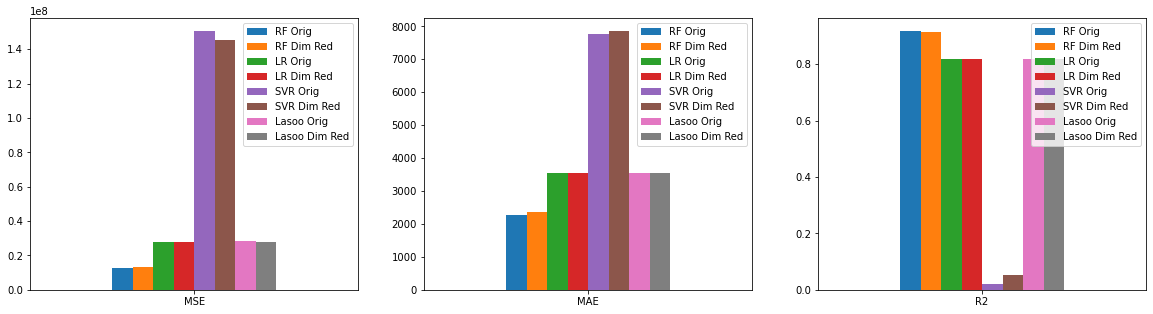

In [36]:
df_mse = pd.DataFrame({
    'RF Orig': RF_orig_mse,'RF Dim Red': RF_mse,
    'LR Orig': LR_orig_mse, 'LR Dim Red': LR_mse,
    'SVR Orig': SVR_orig_mse, 'SVR Dim Red': SVR_mse,
    'Lasoo Orig': Lasoo_orig_mse, 'Lasoo Dim Red': Lasoo_mse}, index=['MSE'])
df_mae = pd.DataFrame({
    'RF Orig': RF_orig_mae,'RF Dim Red': RF_mae, 
    'LR Orig': LR_orig_mae, 'LR Dim Red': LR_mae, 
    'SVR Orig': SVR_orig_mae, 'SVR Dim Red': SVR_mae, 
    'Lasoo Orig': Lasoo_orig_mae, 'Lasoo Dim Red': Lasoo_mae}, index=['MAE'])
df_r2 =  pd.DataFrame({
    'RF Orig': RF_orig_r2 ,'RF Dim Red': RF_r2 ,
    'LR Orig': LR_orig_r2 , 'LR Dim Red': LR_r2 ,
    'SVR Orig': SVR_orig_r2 ,'SVR Dim Red': SVR_r2 ,
    'Lasoo Orig': Lasoo_orig_r2,'Lasoo Dim Red': Lasoo_r2 }, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])
axes[0].legend(loc="best")
axes[1].legend(loc="best")
axes[2].legend(loc="best")


plt.show()

## TASK 2 Conclusion:

I first baselined the regression algorithms without dimensional reduction so I could compare the dimension reduction results against these.

Random Forest seems to perform best for regression, it has the lowest Mean Average Error (MAE), and Mean Squared Error (MSE) and the higher R2 (Mean squared Error). It also reduced the dimensions from 8 to 4 with little loss of performance.

Linear regression did not perform as well as Random Forest, but interestingly the performance of Linear regression improved with the dimensions reduced. 

I added the SVR regression algorithm, and it performed very poorly indeed, much higher MAE and MSE and much lower R2.

Disappointed with the SVR result I tried Lasoo, which perorms very similarly to the Linear Regression, which is unsurprising as Lasoo is a modification of linear regression, where the model is penalized for the sum of absolute values of the weights .

## TASK 3

Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).


### Dimensionality Reduction Analysis Methods

I added 4 of these in the end as the performance of the first ones I added did not exceed the original ones from the training notebook.

 - **LinearDiscriminantAnalysis**: A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method.
 - **Isomap**: Method based on projecting vectors from each manifold to try and assemble the structure
 - **UMAP**: Uniform Manifold Approximation and Projection (UMAP).  Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can preserve as much of the local, and more of the global data structure as compared to t-SNE, with a shorter runtime
 - **TSNE**: Method based on Distributed Stochastic Neighbor Embedding. It calculates the probability similarity of points in high dimensional space as well as in low dimensional space

### Random forest pipeline - All Dimension Reduction Methods

In [37]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [38]:
N_FEATURES_OPTIONS = [2,4,6]
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())], # ,RFE(RandomForestRegressor())
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [umap.UMAP()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [TSNE()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_new_best_params = search.best_params_
RF_new_best_model = search.best_estimator_

Best CV score = 0.833:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__max_depth': 4}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.12052826 0.18430925 0.2088502  0.23706271 0.35419911 0.38199684
 0.50898379 0.67792637 0.71063112 0.67652147 0.68010893 0.66912089
 0.80210569 0.83195442 0.82271429 0.80414944 0.82995511 0.82183695
 0.67783009 0.68073165 0.66757628 0.80187795 0.83313674 0.8160851
 0.80197374 0.83190565 0.82305571        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.41589196 0.50157049 0.49909271 0.48538887 0.55030379 0.56766049
 0.48850815 0.54258134 0.56578771 0.48844803 0.59872969 0.61217498
 0.41794168 0.62204081 0.67309832 0.48358784 0.62722525 0.63072097
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


### Linear regression pipeline  - All Dimension Reduction Methods

In [39]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [40]:
N_FEATURES_OPTIONS = [2,4,6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    { ### PCA - PCA is a technique which helps us in extracting a new set of variables from an existing large set of variables. These newly extracted variables are called Principal Components.
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### Backward Feature Elimination - take all variables and model them, then calculate performance. Systematically remove features one at a time and remove the variables which impact performance the least
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method.
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### Method based on projecting vectors from each manifold to try and assemble the structure
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### Uniform Manifold Approximation and Projection (UMAP).  Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can preserve as much of the local, and more of the global data structure as compared to t-SNE, with a shorter runtime
        'reduce_dim': [umap.UMAP()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ###  Method based on Distributed Stochastic Neighbor Embedding. It calculates the probability similarity of points in high dimensional space as well as in low dimensional space
        'reduce_dim': [TSNE()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_new_best_params = search.best_params_
LR_new_best_model = search.best_estimator_

Best CV score = 0.721:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__normalize': False}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.03499188 0.03499188 0.20681135 0.20681135 0.69869753 0.69869753
 0.69542998 0.69542998 0.72061896 0.72061896 0.71949696 0.71949696
 0.69542998 0.69542998 0.72114869 0.72114869 0.72096698 0.72096698
        nan        nan        nan        nan        nan        nan
 0.17179224 0.17179224 0.23833938 0.23833938 0.26887826 0.26887826
 0.0110851  0.02006026 0.07126481 0.0660772  0.25109737 0.22238502
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


### SVR Pipeline - All Dimension Reduction Methods

In [41]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR())])


In [42]:
N_FEATURES_OPTIONS = [2,4,6]
KERNEL_OPTIONS = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
GAMMA_OPTIONS = ["scale", "auto"]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    { ### A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method.
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    { ### Method based on projecting vectors from each manifold to try and assemble the structure
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    { ### Uniform Manifold Approximation and Projection (UMAP).  Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can preserve as much of the local, and more of the global data structure as compared to t-SNE, with a shorter runtime
        'reduce_dim': [umap.UMAP()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    },
    { ###  Method based on Distributed Stochastic Neighbor Embedding. It calculates the probability similarity of points in high dimensional space as well as in low dimensional space
        'reduce_dim': [TSNE()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL_OPTIONS,
        'regresson__gamma': GAMMA_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_new_best_params = search.best_params_
SVR_new_best_model = search.best_estimator_


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.10401163 -0.10490754 -0.1082644  -0.10803204         nan -0.10401163
 -0.09720964 -0.10823494 -0.10792214         nan -0.09586311 -0.10537034
 -0.10768854 -0.10676989         nan -0.09586311 -0.10267936 -0.10773044
 -0.10654785         nan -0.03555148 -0.10155705 -0.10466028 -0.0993768
         nan -0.03555148 -0.09782766 -0.10489636 -0.09841669         nan
 -0.0391341  -0.00484182 -0.09569629 -0.08669832         nan -0.0391341
 -0.00484182 -0.09569629 -0.08669832         nan -0.03788615 -0.08784646
 -0.10202578 -0.09459262         nan -0.03788615 -0.08784646 -0.10202578
 -0.09459262         nan -0.03832011 -0.09989337 -0.10431864 -0.098453
         nan -0.03832011 -0.09989337 -0.10431864 -0.098453           nan
 -0.0391341  -0.00484182 -0.09569629 -0.08669832         nan -0.0391341
 -0.00484182 -0.09569629 -0.08669832         nan -0.0375369

Best CV score = 0.602:
Best parameters:  {'reduce_dim': UMAP(n_components=6), 'reduce_dim__n_components': 6, 'regresson__gamma': 'auto', 'regresson__kernel': 'poly'}


### Lasoo Pipeline - All Dimension Reduction Methods

In [43]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', linear_model.Lasso(alpha=1.0))])


In [44]:
N_FEATURES_OPTIONS =[2,4,6]
NORMALIZE_OPTIONS = [True, False]
GAMMA_OPTIONS = ["scale", "auto"]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method.
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### Method based on projecting vectors from each manifold to try and assemble the structure
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ### Uniform Manifold Approximation and Projection (UMAP).  Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can preserve as much of the local, and more of the global data structure as compared to t-SNE, with a shorter runtime
        'reduce_dim': [umap.UMAP()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    { ###  Method based on Distributed Stochastic Neighbor Embedding. It calculates the probability similarity of points in high dimensional space as well as in low dimensional space
        'reduce_dim': [TSNE()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
Lasoo_new_best_params = search.best_params_
Lasoo_new_best_model = search.best_estimator_

Best CV score = 0.721:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.03500482 0.03499257 0.20676171 0.20681032 0.69868614 0.69869822
 0.69545004 0.69543108 0.72083106 0.72062698 0.71982685 0.71950959
 0.69545004 0.69543108 0.72123628 0.72115253 0.72124906 0.72097837
        nan        nan        nan        nan        nan        nan
 0.17194219 0.17179186 0.23838743 0.23833409 0.2688641  0.26887594
 0.02546369 0.00548906 0.08768092 0.13440469 0.27437225 0.28091777
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


### Assess the effectiveness of the newly found best models for

In [45]:
RF_mse_new, RF_mae_new, RF_r2_new = evaluate_model(X_test, y_test, RF_new_best_model)
LR_mse_new, LR_mae_new, LR_r2_new = evaluate_model(X_test, y_test, LR_new_best_model)
SVR_mse_new, SVR_mae_new, SVR_r2_new = evaluate_model(X_test, y_test, SVR_new_best_model)
Lasoo_mse_new, Lasoo_mae_new, Lasoo_r2_new = evaluate_model(X_test, y_test, Lasoo_new_best_model)

### Graph the performance of the models

Understanding the graph legend:  
 - **Orig**: This represents the performance of the algorithm without dimension reduction
 - **Dim Red**: This represents the results of the dimension reduction which followed the training notebook
 - **New**: This represents the results of the dimension reduction which includes the 4 added methods

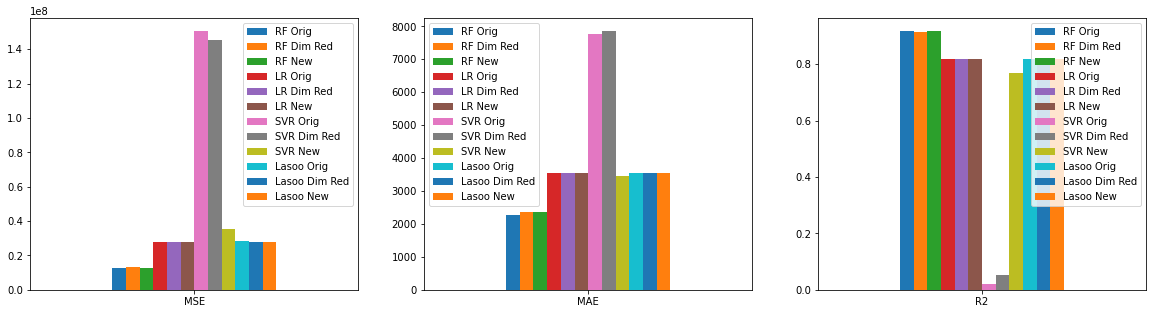

In [46]:
df_mse = pd.DataFrame({
    'RF Orig': RF_orig_mse,'RF Dim Red': RF_mse, 'RF New': RF_mse_new,
    'LR Orig': LR_orig_mse, 'LR Dim Red': LR_mse, 'LR New': LR_mse_new,
    'SVR Orig': SVR_orig_mse, 'SVR Dim Red': SVR_mse,'SVR New': SVR_mse_new,
    'Lasoo Orig': Lasoo_orig_mse, 'Lasoo Dim Red': Lasoo_mse, 'Lasoo New': Lasoo_mse_new}, index=['MSE'])
df_mae = pd.DataFrame({
    'RF Orig': RF_orig_mae,'RF Dim Red': RF_mae, 'RF New': RF_mae_new,
    'LR Orig': LR_orig_mae, 'LR Dim Red': LR_mae, 'LR New': LR_mae_new, 
    'SVR Orig': SVR_orig_mae, 'SVR Dim Red': SVR_mae,'SVR New': SVR_mae_new,
    'Lasoo Orig': Lasoo_orig_mae, 'Lasoo Dim Red': Lasoo_mae, 'Lasoo New': Lasoo_mae_new}, index=['MAE'])
df_r2 =  pd.DataFrame({
    'RF Orig': RF_orig_r2 ,'RF Dim Red': RF_r2 ,'RF New': RF_r2_new ,
    'LR Orig': LR_orig_r2 , 'LR Dim Red': LR_r2 , 'LR New': LR_r2_new, 
    'SVR Orig': SVR_orig_r2 ,'SVR Dim Red': SVR_r2 ,'SVR New': SVR_r2_new,
    'Lasoo Orig': Lasoo_orig_r2,'Lasoo Dim Red': Lasoo_r2, 'Lasoo New': Lasoo_r2_new }, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## Train a Final Model
Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [47]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_new_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_new_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

## Task 3 Conclusion:

For task 4 I added a few dimension reducing methods.  
 - LinearDiscriminantAnalysis 
 - Isomap
 - UMAP
 - TSNE
 
I checked my 4 regression algorithms against 6 dimension reduction methods  
 - **RandomForestRegressor**: Interestingly I find a slightly better RFE estimator the second time. It performs very much in line with the original regression, but with only 4 features (it was 6 the first time), which is quite an impressive result. When we examined the significant features for Random Forest we found 4 features, so this matches nicely.  
 - **Linear Regression**: No improvement was detected and the RFE method with LinearRegression estimator is selected as the best both times.  
 - **SVR**: Significant Improvement: The original performance was appalling. Using UMAP the performance is significantly improved by using UMAP for dimensional reduction. The performance is still the worst, however, it does come into line with the other approaches now.
 - **Lasoo**: Unsurprisingly, Lasoo selects the same RFE method as Linear Regression with the same performance.
 
#### The best performance overall was RandomForestRegressor:  
 Best CV score = 0.833:  
 Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), **n_features_to_select=4**), 'reduce_dim__n_features_to_select': 4, 'regresson__max_depth': 4}